In [1]:
import functools
import os

In [237]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate, stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [5]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [6]:
redshift_sim = h5py.File(
    lib.const.REDSHIFT_CATALOGS[shear_step],
)

In [7]:
zbinsc = redshift_sim["sompz"]["pzdata_weighted_sompz_dz005"]["zbinsc"][:]

nz_sompz = {}
nz_true = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz = redshift_sim["sompz"]["pzdata_weighted_sompz_dz005"][f"bin{tomographic_bin}"][:]
    _nz_true = redshift_sim["sompz"]["pzdata_weighted_true_dz005"][f"bin{tomographic_bin}"][:]
    
    nz_sompz[tomographic_bin] = _nz # / np.sum(_nz) / (zhigh - zlow)
    nz_true[tomographic_bin] = _nz_true # / np.sum(_nz) / (zhigh - zlow)
    

In [8]:
shear_sim = h5py.File(
    lib.const.IMSIM_CATALOGS[shear_step],
)

In [9]:
truth_match = h5py.File(
    lib.const.MATCH_CATALOGS[shear_step],
)

In [10]:
_, shear_sim_index, redshift_sim_index = np.intersect1d(
    shear_sim["mdet/noshear"]["uid"][:],
    redshift_sim["sompz/noshear"]["coadd_object_id"][:],
    return_indices=True,
)

In [11]:
np.testing.assert_equal(
    shear_sim["mdet/noshear"]["uid"][:][shear_sim_index],
    redshift_sim["sompz/noshear"]["coadd_object_id"][:][redshift_sim_index],
)

In [12]:
bhat_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim[shear_sim_index] = redshift_sim["sompz/noshear"]["bhat"][:][redshift_sim_index]

In [13]:
cell_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
cell_sim[shear_sim_index] = redshift_sim["sompz/noshear"]["cell_wide"][:][redshift_sim_index]

In [14]:
weights_sim = lib.weights.get_shear_weights(shear_sim["mdet/noshear"])

In [15]:
response_sim = lib.response.get_shear_response(shear_sim["mdet/noshear"])

In [16]:
count_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
occupancy_grid_sim = count_grid_sim / sum(count_grid_sim)

In [17]:
_weight_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    weights_sim,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
weight_grid_sim = _weight_grid_sim / sum(_weight_grid_sim)

In [18]:
_response_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    response_sim,
    statistic="mean",
    bins=lib.const.CELL_IDS,
)
response_grid_sim = _response_grid_sim

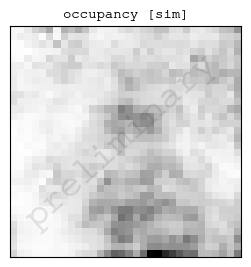

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    occupancy_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("occupancy [sim]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

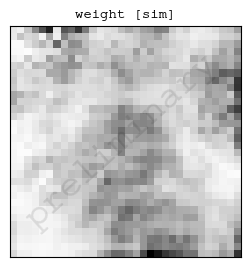

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    weight_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("weight [sim]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

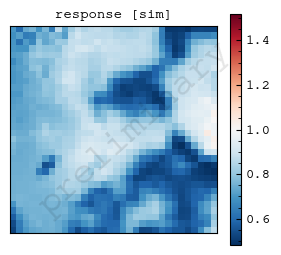

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

norm=mpl.colors.CenteredNorm(1)

m = axs.imshow(
    response_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m)
axs.set_title("response [sim]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [22]:
# extend the last bin and "pileup"
zvals = lib.const.ZVALS
zedges = lib.const.ZEDGES
_zedges = np.copy(zedges)

np.testing.assert_allclose(
    zbinsc,
    zvals,
)

# zvals = 0.5 * (zedges[:-1] + zedges[1:])
# # zedges = np.linspace(0, 3, 301)
# zvals[0] = 0.
_zedges[-1] = 4.

_sum_weight, _, _, _ = stats.binned_statistic_2d(
    cell_sim,
    truth_match["mdet/noshear"]["z"],
    weights_sim * response_sim,
    statistic="sum",
    bins=[lib.const.CELL_IDS, _zedges],
)

# manually force n(0) = 0
# _sum_weight[:, 0] = 0

# renormalize
# nz = _sum_weight / np.sum(_sum_weight, axis=1)[:, np.newaxis]
# nz = _sum_weight / np.diff(lib.const.ZEDGES)
# nz /= nz.sum()
nz = _sum_weight

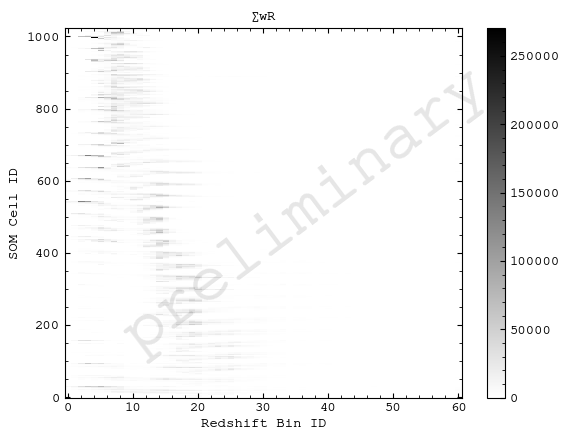

In [23]:
fig, axs = plt.subplots(1, 1,)

im = axs.imshow(
    nz,
    origin="lower",
    vmin=0
)
axs.set_xlabel("Redshift Bin ID")
axs.set_ylabel("SOM Cell ID")
axs.set_title("$\\sum w R$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

watermark(fig)

plt.show()

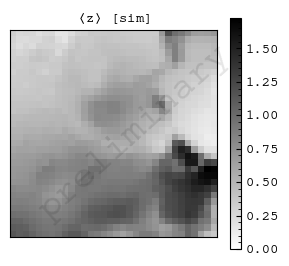

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    (
        np.sum(zvals * nz, axis=1) 
        / np.sum(nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0
)
axs.set_title("$〈z〉$ [sim]")

fig.colorbar(im, ax=axs)

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [25]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        cell_sim[bhat_sim == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

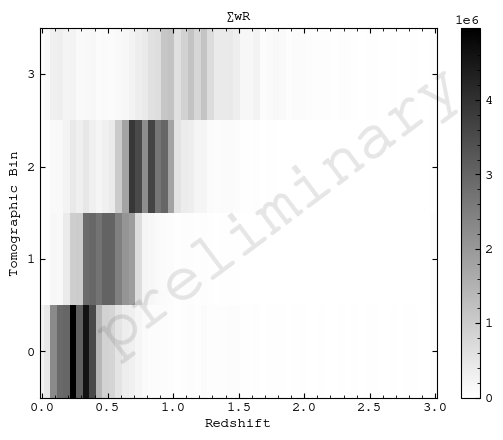

In [26]:
fig, axs = plt.subplots(1, 1,)

im = axs.pcolormesh(
    zvals,
    lib.const.TOMOGRAPHIC_BINS,
    np.array(
        [
            np.sum(
                nz[cell_assignments[tomographic_bin]],
                axis=0,
            )
            for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
        ]
    ),
    vmin=0
)
axs.set_xlabel("Redshift")
axs.set_ylabel("Tomographic Bin")
axs.set_title("$\\sum w R$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

# axs.set_xticks([])
axs.set_yticks([0, 1, 2, 3])
axs.set_yticks([], minor=True)

watermark(fig)

plt.show()

---

# Nominal

In [27]:
nz_tomo = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]],
        axis=0,
    )
    
    # manually force n(0) = 0
    nz_tomo[tomographic_bin][0] = 0

    # renormalize
    nz_tomo[tomographic_bin] = nz_tomo[tomographic_bin] / np.sum(nz_tomo[tomographic_bin]) / np.diff(zedges)

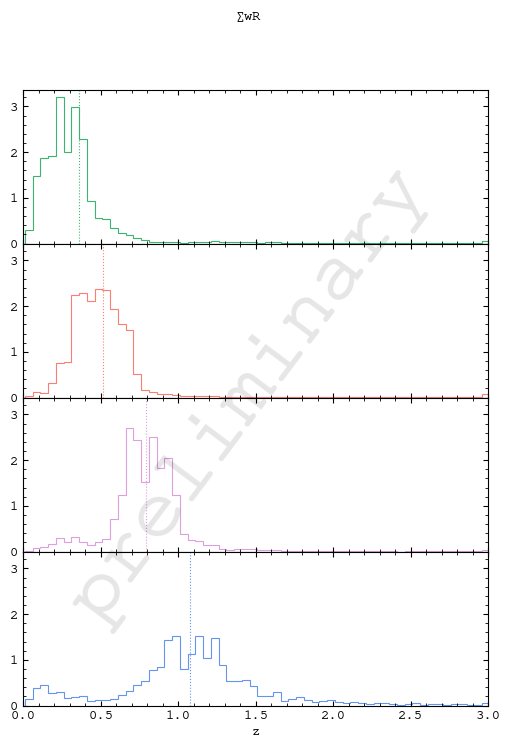

In [28]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zvals, weights=nz_tomo[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo[i],
        edges=zedges,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

fig.suptitle("$\\sum w R$")

watermark(fig)

plt.show()

---

# Comparison

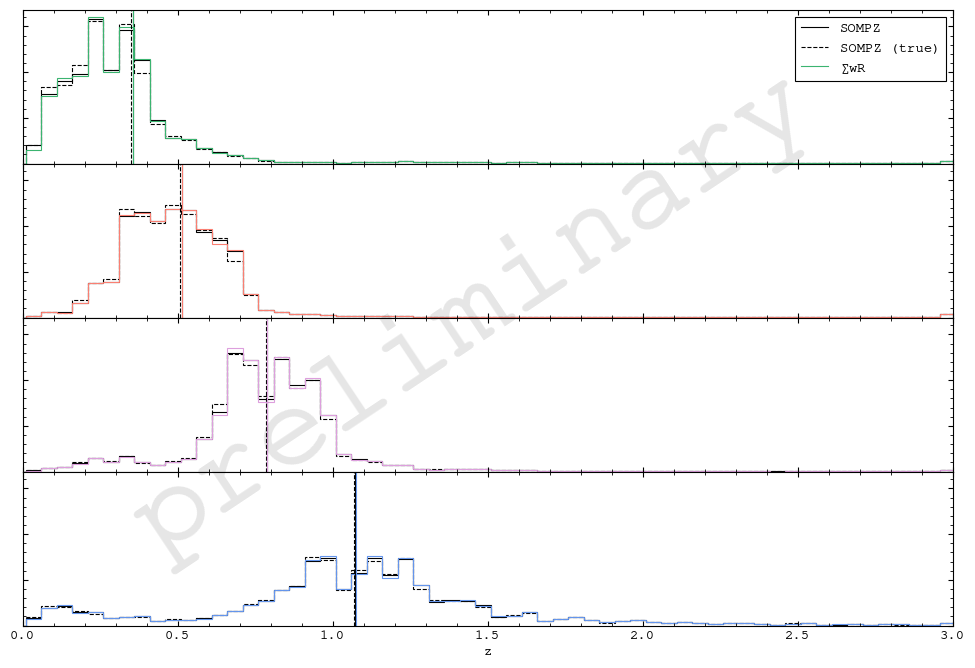

In [29]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_sompz[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_sompz[i],
        edges=zedges,
        ec="k",
        ls="-",
        label="SOMPZ",
    )
    axs[i].axvline(
        np.average(zbinsc, weights=nz_true[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_true[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="SOMPZ (true)",
    )
    
    axs[i].axvline(
        np.average(zvals, weights=nz_tomo[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_tomo[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="-",
        label="$\\sum w R$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

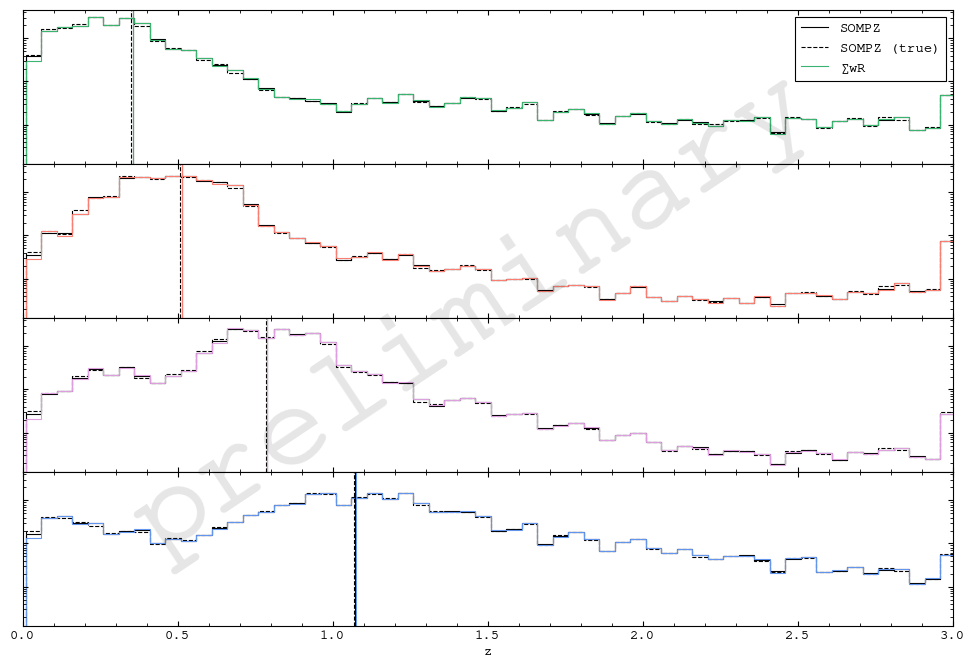

In [30]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_sompz[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_sompz[i],
        edges=zedges,
        ec="k",
        ls="-",
        label="SOMPZ",
    )
    axs[i].axvline(
        np.average(zbinsc, weights=nz_true[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_true[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="SOMPZ (true)",
    )
    
    axs[i].axvline(
        np.average(zvals, weights=nz_tomo[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_tomo[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="-",
        label="$\\sum w R$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

In [31]:
print("mean z")
print(
    f"bin"
    f"\tSOMPZ"
    f"\twR"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc, weights=nz_sompz[i]) :.4f}"
        f"\t{np.average(zvals, weights=nz_tomo[i]) :.4f}"
    )


mean z
bin	SOMPZ	wR
0	0.3558	0.3573
1	0.5139	0.5139
2	0.7889	0.7893
3	1.0740	1.0759


In [32]:
print("dz")
print(
    f"bin"
    f"\tSOMPZ - wR"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}\t{np.average(zbinsc, weights=nz_sompz[i]) - np.average(zvals, weights=nz_tomo[i]) :.4f}"
    )
 

dz
bin	SOMPZ - wR
0	-0.0015
1	-0.0000
2	-0.0004
3	-0.0019


In [33]:
print("ks test")
print(
    f"bin"
    f"\tp-value (SOMPZ, wR)"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    ks = stats.kstest(
        nz_sompz[i],
        nz_tomo[i],
    )
    print(
        f"{i}\t{ks.pvalue :.4f}"
    )

ks test
bin	p-value (SOMPZ, wR)
0	1.0000
1	1.0000
2	1.0000
3	1.0000


In [34]:
from boyan import Tz, rebin

In [238]:
t = Tz(0.05,60,z0=0.035)

In [239]:
_Z = truth_match["mdet/noshear"]["z"][:]

In [240]:
nz_true_object = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    zbins = np.arange(0,6,0.01)
    nz = np.histogram(Z, zbins, weights=response_weight, density=True)[0]

    #Pileup at z=3
    nz[299] = np.sum(nz[299:])
    nz = nz[:300]

    #Convert to Tz and dz=0.05
    z = np.arange(0.035,3,0.05)
    z = np.concatenate((np.array([0]), z))
    y = rebin(nz)
    dndz_true = t.dndz(y, z)
    
    nz_true_object[tomographic_bin] = dndz_true
    

In [38]:
nz_true_som = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    zbins = np.arange(0,6,0.01)
    _nz, _, _, _ = stats.binned_statistic_2d(
        cell_sim,
        _Z,
        weights_sim * response_sim,
        statistic="sum",
        bins=[lib.const.CELL_IDS, zbins],
    )
    nz = np.sum(
        _nz[cell_assignments[tomographic_bin]],
        axis=0,
    ) / np.sum(_nz) / np.diff(zbins)

    #Pileup at z=3
    nz[299] = np.sum(nz[299:])
    nz = nz[:300]

    #Convert to Tz and dz=0.05
    z = np.arange(0.035,3,0.05)
    z = np.concatenate((np.array([0]), z))
    y = rebin(nz)
    dndz_true = t.dndz(y, z)
    
    nz_true_som[tomographic_bin] = dndz_true
    

In [39]:
print("mean z")
print(
    f"bin"
    f"\tSOMPZ [true]"
    f"\twR [object]"
    f"\twR [som]"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc, weights=nz_true[i]) :.4f}"
        "\t"
        f"\t{np.average(zvals, weights=nz_true_object[i]) :.4f}"
        "\t"
        f"\t{np.average(zvals, weights=nz_true_som[i]) :.4f}"
    )


mean z
bin	SOMPZ [true]	wR [object]	wR [som]
0	0.3513		0.3513		0.3513
1	0.5090		0.5090		0.5090
2	0.7843		0.7843		0.7843
3	1.0698		1.0698		1.0698


In [40]:
print("dz")
print(
    f"bin"
    f"\tSOMPZ [true] - wR [object]"
    f"\tSOMPZ [true] - wR [som]"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc, weights=nz_true[i]) - np.average(zvals, weights=nz_true_object[i]) :.4f}"
        "\t\t\t"
        f"\t{np.average(zbinsc, weights=nz_true[i]) - np.average(zvals, weights=nz_true_som[i]) :.4f}"
    )
 

dz
bin	SOMPZ [true] - wR [object]	SOMPZ [true] - wR [som]
0	0.0000				0.0000
1	0.0000				0.0000
2	0.0000				0.0000
3	-0.0000				-0.0000


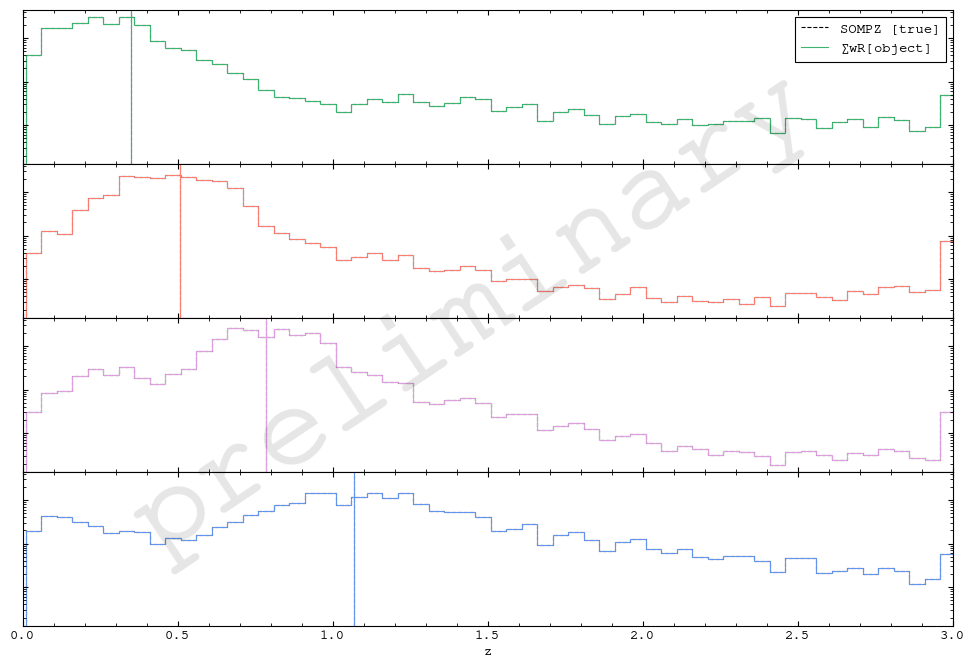

In [41]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_true[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_true[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="SOMPZ [true]",
    )
    
    axs[i].axvline(
        np.average(zvals, weights=nz_true_object[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_true_object[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="-",
        label="$\\sum w R [object]$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

In [370]:
zbins_001 = np.arange(0, 6, 0.01)

zbins_005 = np.arange(0, 6, 0.05)

In [289]:
zvals_005 = np.concatenate([[0], np.arange(0.035, 3, 0.05)])
zedges_005 = np.concatenate(
    [
        [0],
        np.linspace(
            0.0,
            3.0,
            len(zvals_005),
        ) + 0.01,
    ]
)

In [303]:
zvals_001 = np.concatenate([[0], np.arange(0.005, 3, 0.01)])
zedges_001 = np.concatenate(
    [
        [0],
        np.linspace(
            0.0,
            3.0,
            len(zvals_001),
        ) + 0.01,
    ]
)

In [363]:
def rebin_001_to_005(nz):
    redshift_original = np.append(nz, np.array([0, 0]))
    zbinsc_laigle = np.arange(0, 3.02, 0.01)
    zbinsc_integrate = np.arange(0.015, 3.015, 0.01)

    interp_func = interpolate.interp1d(zbinsc_laigle, redshift_original, kind='linear', axis=0, bounds_error=False, fill_value=0)
    values = interp_func(zbinsc_integrate)


    values = values.reshape((60, 5))
    redshift_integrated = np.sum(values, axis=1)
    
    return redshift_integrated

def rebin_005_to_001(nz):
    redshift_original = np.append(nz, np.array([0, 0]))
    zbinsc_laigle = np.arange(0, 3.10, 0.05)
    zbinsc_integrate = np.arange(0.015, 3.015, 0.002)  # np.arange(0.015, 3.015, 0.05)

    interp_func = interpolate.interp1d(zbinsc_laigle, redshift_original, kind='linear', axis=0, bounds_error=False, fill_value=0)
    values = interp_func(zbinsc_integrate)


    values = values.reshape((300, 5))
    redshift_integrated = np.sum(values, axis=1)
    
    return redshift_integrated

In [307]:
t_005 = Tz(0.05, 60, z0=0.035)
t_001 = Tz(0.01, 300, z0=0.005)

In [308]:
nz_direct_005 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    _zedges_005 = np.copy(zedges_005)
    _zedges_005[-1] = np.inf  # pileup in last bin
    nz = np.histogram(Z, _zedges_005, weights=response_weight)[0]

    # #Pileup at z=3
    # idx = np.min(np.where(_zbins_005 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz = nz[:idx + 1]

    # nz = np.concatenate((np.array([0]), nz))

    nz[0] = 0
    nz_direct_005[tomographic_bin] = nz / np.sum(nz) / np.diff(zedges_005)
    

In [350]:
nz_rebin_005 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    nz = np.histogram(Z, zbins_001, weights=response_weight, density=True)[0]

    #Pileup at z=3
    idx = np.min(np.where(zbins_001 >= 3)) - 1
    nz[idx] = np.sum(nz[idx:])
    nz = nz[:idx + 1]

    #Convert to Tz and dz=0.05
    y = rebin_001_to_005(nz)
    dndz_true = t_005.dndz(y, zvals_005)
    
    nz_rebin_005[tomographic_bin] = dndz_true
    

In [351]:
print("mean z")
print(
    f"bin"
    f"\tdirect"
    f"\trebin"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_005, weights=nz_direct_005[i]) :.4f}"
        "\t"
        f"\t{np.average(zvals_005, weights=nz_rebin_005[i]) :.4f}"
    )


mean z
bin	direct	rebin
0	0.3575		0.3513
1	0.5144		0.5090
2	0.7897		0.7843
3	1.0763		1.0698


In [352]:
print("dz")
print(
    f"bin"
    f"\trebin - direct"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_005, weights=nz_rebin_005[i]) - np.average(zvals_005, weights=nz_direct_005[i]) :.4f}"
    )
 

dz
bin	rebin - direct
0	-0.0062
1	-0.0054
2	-0.0054
3	-0.0066


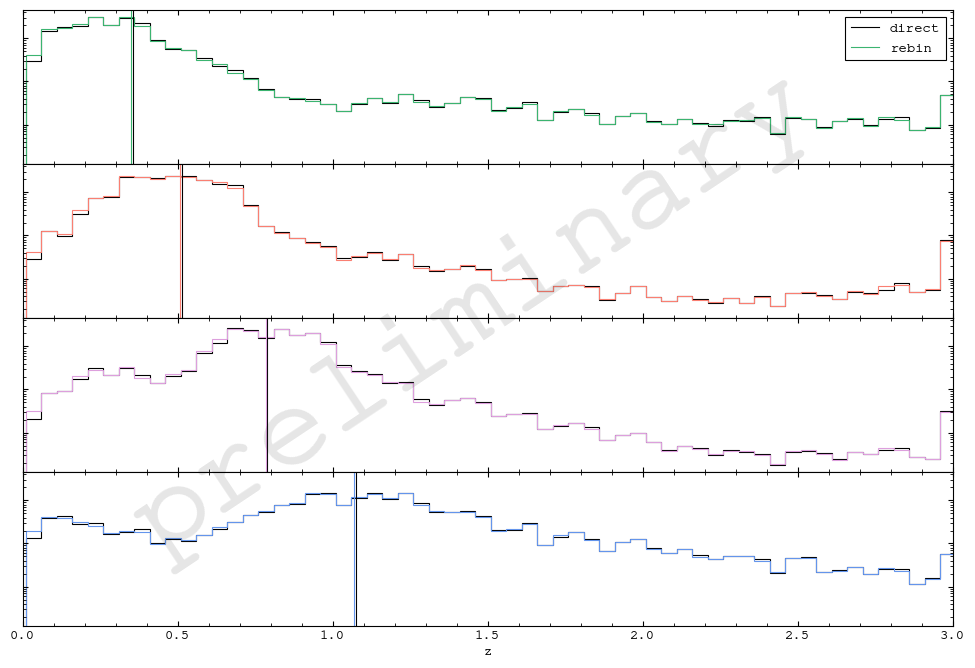

In [313]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zvals_005, weights=nz_direct_005[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_direct_005[i],
        edges=zedges_005,
        ec="k",
        ls="-",
        label="direct",
    )
    
    axs[i].axvline(
        np.average(zvals_005, weights=nz_rebin_005[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_rebin_005[i],
        edges=zedges_005,
        ec=tomo_colors[i],
        ls="-",
        label="rebin",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

In [314]:
nz_direct_001 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    _zedges_001 = np.copy(zedges_001)
    _zedges_001[-1] = np.inf  # pileup in last bin
    nz = np.histogram(Z, _zedges_001, weights=response_weight)[0]

    # #Pileup at z=3
    # idx = np.min(np.where(_zbins_005 >= 3)) - 1
    # nz[idx] = np.sum(nz[idx:])
    # nz = nz[:idx + 1]

    # nz = np.concatenate((np.array([0]), nz))

    nz[0] = 0
    nz_direct_001[tomographic_bin] = nz / np.sum(nz) / np.diff(zedges_001)
    

In [364]:
nz_rebin_001 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    bhat_msk = np.where(np.isin(
        cell_sim,
        cell_assignments[tomographic_bin],
    ) == True)[0]

    Z = _Z[bhat_msk]
    response_weight = (weights_sim * response_sim)[bhat_msk]
    nz = np.histogram(Z, zbins_005, weights=response_weight, density=True)[0]

    #Pileup at z=3
    idx = np.min(np.where(zbins_005 >= 3)) - 1
    nz[idx] = np.sum(nz[idx:])
    nz = nz[:idx + 1]

    #Convert to Tz and dz=0.01
    y = rebin_005_to_001(nz)
    dndz_true = t_001.dndz(y, zvals_001)
    
    nz_rebin_001[tomographic_bin] = dndz_true
    

In [369]:
print("mean z")
print(
    f"bin"
    f"\tdirect"
    f"\trebin"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_001, weights=nz_direct_001[i]) :.4f}"
        "\t"
        f"\t{np.average(zvals_001, weights=nz_rebin_001[i]) :.4f}"
    )


mean z
bin	direct	rebin
0	0.3466		0.3204
1	0.5042		0.4763
2	0.7798		0.7514
3	1.0663		1.0405


In [368]:
print("dz")
print(
    f"bin"
    f"\trebin - direct"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zvals_001, weights=nz_rebin_001[i]) - np.average(zvals_001, weights=nz_direct_001[i]) :.4f}"
    )
 

dz
bin	rebin - direct
0	-0.0263
1	-0.0279
2	-0.0285
3	-0.0258


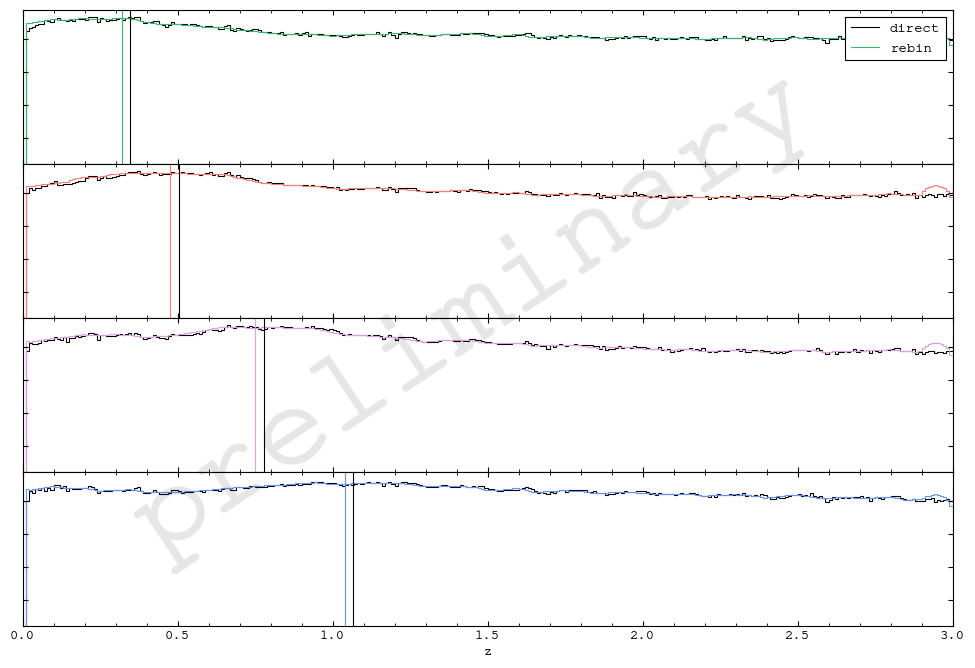

In [367]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zvals_001, weights=nz_direct_001[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_direct_001[i],
        edges=zedges_001,
        ec="k",
        ls="-",
        label="direct",
    )
    
    axs[i].axvline(
        np.average(zvals_001, weights=nz_rebin_001[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_rebin_001[i],
        edges=zedges_001,
        ec=tomo_colors[i],
        ls="-",
        label="rebin",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

In [82]:
bhat_sim = {}
cell_sim = {}
weight_sim = {}
response_sim = {}

In [83]:
for mdet_step in ["noshear", "1p", "1m"]:
    _, _shear_sim_index, _redshift_sim_index = np.intersect1d(
        shear_sim["mdet"][mdet_step]["uid"],
        redshift_sim["sompz"][mdet_step]["coadd_object_id"],
        return_indices=True,
    )
    
    _bhat_sim = np.full(shear_sim["mdet"][mdet_step]["uid"].shape, np.nan)
    _bhat_sim[_shear_sim_index] = redshift_sim["sompz"][mdet_step]["bhat"][:][_redshift_sim_index]
    
    _cell_sim = np.full(shear_sim["mdet"][mdet_step]["uid"].shape, np.nan)
    _cell_sim[_shear_sim_index] = redshift_sim["sompz"][mdet_step]["cell_wide"][:][_redshift_sim_index]

    _weights_sim = lib.weights.get_shear_weights(shear_sim["mdet"][mdet_step])

    _response_sim = lib.response.get_shear_response(shear_sim["mdet"][mdet_step])

    bhat_sim[mdet_step] = _bhat_sim
    cell_sim[mdet_step] = _cell_sim
    weight_sim[mdet_step] = _weights_sim
    response_sim[mdet_step] = _response_sim

In [80]:
g1_sim = {
    mdet_step: shear_sim["mdet"][mdet_step]["gauss_g_1"][:]
    for mdet_step in lib.const.MDET_STEPS
}

g2_sim = {
    mdet_step: shear_sim["mdet"][mdet_step]["gauss_g_2"][:]
    for mdet_step in lib.const.MDET_STEPS
}

In [85]:
# response map
mean_g1_sim = {}
mean_g2_sim = {}
for mdet_step in ["1p", "1m"]:
    _sum_weight, _, _ = stats.binned_statistic(
        cell_sim[mdet_step],
        weight_sim[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        cell_sim[mdet_step],
        weight_sim[mdet_step] * g1_sim[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g1_sim[mdet_step] = _sum_g1 / _sum_weight

    _sum_g2, _, _ = stats.binned_statistic(
        cell_sim[mdet_step],
        weight_sim[mdet_step] * g2_sim[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g2_sim[mdet_step] = _sum_g2 / _sum_weight

response_map_sim = (mean_g1_sim["1p"] - mean_g1_sim["1m"]) / (2 * 0.01)

In [98]:
response_grid_sim, _, _ = stats.binned_statistic(
    cell_sim["noshear"],
    response_sim["noshear"],
    statistic="mean",
    bins=lib.const.CELL_IDS,
)

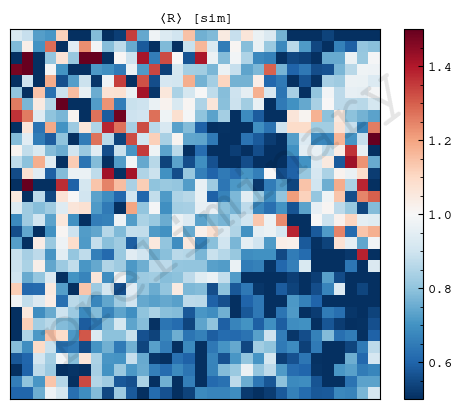

In [87]:
fig, axs = plt.subplots(1, 1)

norm=mpl.colors.CenteredNorm(1, halfrange=0.5)

m = axs.imshow(
    response_map_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m)

axs.set_xticks([])
axs.set_yticks([])
axs.set_title("$〈R〉$ [sim]")

watermark(fig)

plt.show()

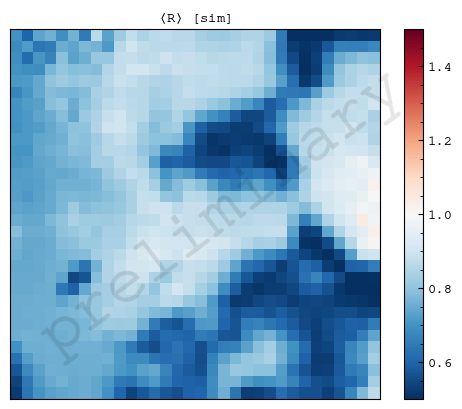

In [101]:
fig, axs = plt.subplots(1, 1)

norm=mpl.colors.CenteredNorm(1, halfrange=0.5)

m = axs.imshow(
    response_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m)

axs.set_xticks([])
axs.set_yticks([])
axs.set_title("$〈R〉$ [sim]")

watermark(fig)

plt.show()

In [60]:
_mask = ~np.isnan(cell_sim["noshear"])

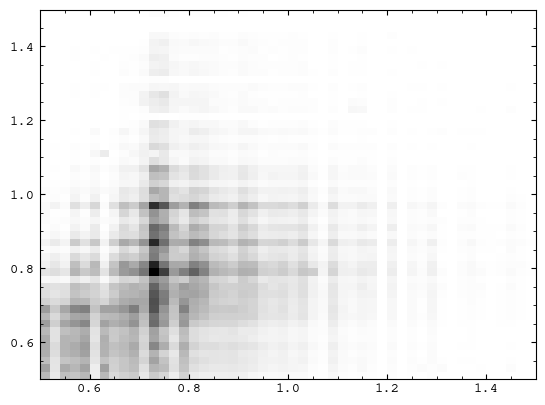

In [93]:
plt.hist2d(
    response_sim["noshear"][_mask],
    response_map_sim[cell_sim["noshear"][_mask].astype(int)],
    bins=[np.linspace(0.5, 1.5, 51), np.linspace(0.5, 1.5, 51)],
)
plt.show()

In [102]:
nz_som_response = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    zbins = np.arange(0,6,0.01)
    _nz, _, _, _ = stats.binned_statistic_2d(
        cell_sim["noshear"][_mask],
        _Z[_mask],
        weight_sim["noshear"][_mask] * response_map_sim[cell_sim["noshear"][_mask].astype(int)],
        statistic="sum",
        bins=[lib.const.CELL_IDS, zbins],
    )
    nz = np.sum(
        _nz[cell_assignments[tomographic_bin]],
        axis=0,
    ) / np.sum(_nz) / np.diff(zbins)

    #Pileup at z=3
    nz[299] = np.sum(nz[299:])
    nz = nz[:300]

    #Convert to Tz and dz=0.05
    z = np.arange(0.035,3,0.05)
    z = np.concatenate((np.array([0]), z))
    y = rebin(nz)
    dndz_true = t.dndz(y, z)
    
    nz_som_response[tomographic_bin] = dndz_true
    

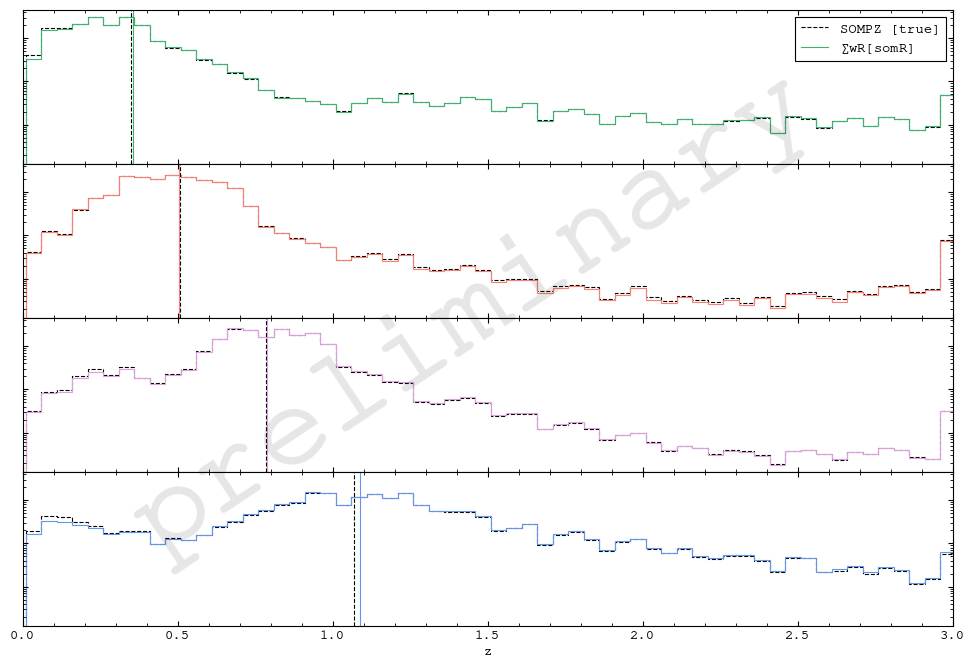

In [103]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_true[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_true[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="SOMPZ [true]",
    )
    
    axs[i].axvline(
        np.average(zvals, weights=nz_som_response[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_som_response[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="-",
        label="$\\sum w R [som R]$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()

In [42]:
shear_y6 = h5py.File(lib.const.Y6_SHEAR_CATALOG)
redshift_y6 = h5py.File(lib.const.Y6_REDSHIFT_CATALOG)

In [115]:
nz_y6 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz = redshift_y6["sompz"]["pzdata_weighted"][f"bin{tomographic_bin}"][:]
    
    #Convert to Tz and dz=0.05
    z = np.arange(0.035,3,0.05)
    z = np.concatenate((np.array([0]), z))
    y = rebin(nz)
    dndz_true = t.dndz(y, z)
    
    nz_y6[tomographic_bin] = dndz_true
    

In [43]:
_, _shear_y6_index, _redshift_y6_index = np.intersect1d(
    shear_y6["mdet/noshear"]["uid"],
    redshift_y6["sompz/noshear"]["coadd_object_id"],
    return_indices=True,
)

bhat_y6 = np.full(shear_y6["mdet/noshear"]["uid"].shape, np.nan)
bhat_y6[_shear_y6_index] = redshift_y6["sompz/noshear"]["bhat"][:][_redshift_y6_index]

cell_y6 = np.full(shear_y6["mdet/noshear"]["uid"].shape, np.nan)
cell_y6[_shear_y6_index] = redshift_y6["sompz/noshear"]["cell_wide"][:][_redshift_y6_index]

weight_y6 = lib.weights.get_shear_weights(shear_y6["mdet/noshear"])
response_y6 = lib.response.get_shear_response(shear_y6["mdet/noshear"])

In [44]:
count_grid_y6, _, _ = stats.binned_statistic(
    cell_y6,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
occupancy_grid_y6 = count_grid_y6 / sum(count_grid_y6)

In [47]:
_weight_grid_y6, _, _ = stats.binned_statistic(
    cell_y6,
    weight_y6,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
weight_grid_y6 = _weight_grid_y6 / sum(_weight_grid_y6)

In [48]:
response_grid_y6, _, _ = stats.binned_statistic(
    cell_y6,
    response_y6,
    statistic="mean",
    bins=lib.const.CELL_IDS,
)

In [50]:
nz_reweight = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    zbins = np.arange(0,6,0.01)
    _nz, _, _, _ = stats.binned_statistic_2d(
        cell_sim,
        _Z,
        weights_sim * response_sim,
        statistic="sum",
        bins=[lib.const.CELL_IDS, zbins],
    )
    nz = np.sum(
        (_nz * (occupancy_grid_y6 / occupancy_grid_sim)[:, np.newaxis])[cell_assignments[tomographic_bin]],
        axis=0,
    ) / np.sum(_nz) / np.diff(zbins)

    #Pileup at z=3
    nz[299] = np.sum(nz[299:])
    nz = nz[:300]

    #Convert to Tz and dz=0.05
    z = np.arange(0.035,3,0.05)
    z = np.concatenate((np.array([0]), z))
    y = rebin(nz)
    dndz_true = t.dndz(y, z)
    
    nz_reweight[tomographic_bin] = dndz_true
    

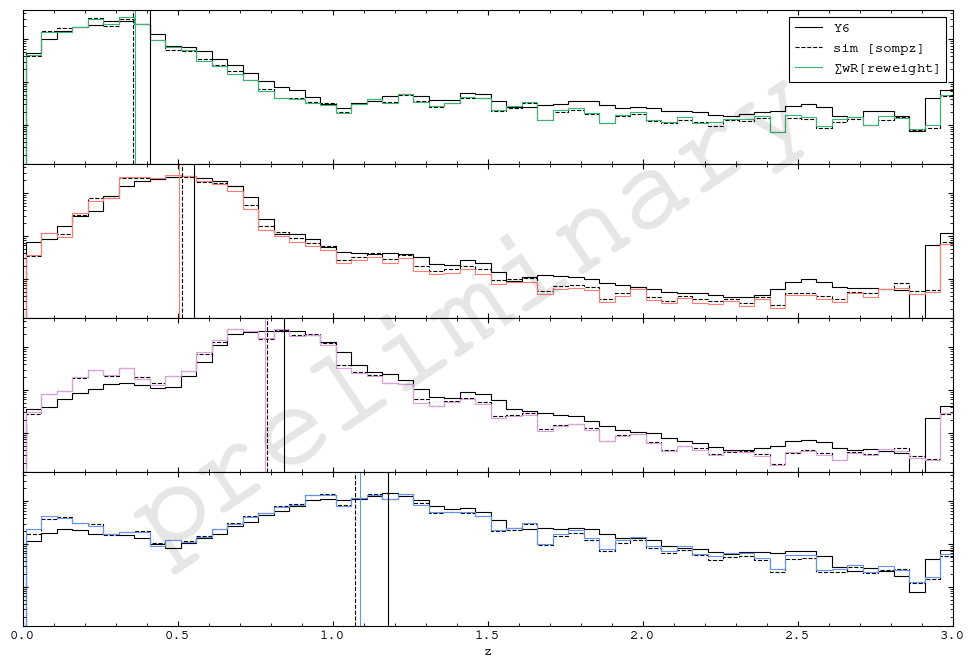

In [117]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_y6[i]),
        c="k",
        ls="-",
    )
    axs[i].stairs(
        nz_y6[i],
        edges=zedges,
        ec="k",
        ls="-",
        label="Y6",
    )
    
    axs[i].axvline(
        np.average(zbinsc, weights=nz_sompz[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_sompz[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="sim [sompz]",
    )
    
    axs[i].axvline(
        np.average(zvals, weights=nz_reweight[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz_reweight[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="-",
        label="$\\sum w R [reweight]$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

watermark(fig)

plt.show()